# Codification des offres du Bon Coin

Attention ce code est compatible python 2.7

Les offres du bon coin contiennent un champ "offre" qui est un intitulé de métier détaillé (plus détaillé qu'une fonction qui est une variable comprenant un nombre fini de modalités).

On cherche à coder les offres en FAP (famille professionnelle), sous leur format agrégé (21 classes identifiées par des lettres). 

La codification ROME, qui est une autre façon de coder les métiers, peut être associée à la codification en FAP de sorte que l'on dispose d'une liste de métiers (environ 15000) et des codes FAP correspondants.

La difficulté provient de ce que les intitulés des offres du Bon Coin ne sont pas formulés exactement comme les intitulés métiers ROME, on va donc étalonner un algorithme sur les intitulés ROME pour l'appliquer ensuite sur les intitulés du bon coin. Notons f cet algorithme, x un intitulé métier et y un code FAP, f est caractérisé par un certain nombre de paramètres qui sont optimisés de sorte que f(x) = y sur les métiers de la codification ROME (évidemment il peut toujours y avoir des erreurs pour certains x). Une fois f déterminé, on applique f à x', intitulé métier du bon coin pour déterminé y'=f(x'), le code FAP inconnu à la base car non disponible dans les métadonnées des offres postées sur le bon coin.

La problématique de "codification automatique" est donc ici un exercice de prédiction. La solution proposée ici est "supervisée" puisqu'on utilise une ressource externe (les codes FAP des intitulés métiers de la codification ROME sont utilisés pour l'étalonnage/apprentissage), mais on pourrait également procéder de façon non supervisée, en comparant les intitulés du bon coin directement avec les intitulés ROME (à l'aide d'une métrique adaptée à la comparaison de chaines de caractères) sans qu'il y ait besoin d'un apprentissage/étalonnage au préalable.

### Import des données 

In [28]:
import pandas as pd
df=pd.read_csv(r'rome_fap_ameliore.csv',encoding='Latin-1', index_col=0)
# les familles de métiers ne possèdent pas de code FAP, on les retire (on conserve les lignes où les codes FAP sont renseignés)
df = df.loc[df['fap2009_SansQualif_agreg']==df['fap2009_SansQualif_agreg']].reset_index(drop=True)
df.head()

,libelle_rome,code_rome,fap2009_SansQualif_agreg,fap2009_AvecQualif_agreg
0,Opérateur / Opératrice d'épandage,A1101,A,Z
1,Débardeur / Débardeuse,A1101,A,Z
2,Conducteur / Conductrice de machines à vendanger,A1101,A,Z
3,Conducteur / Conductrice d'abatteuses,A1101,A,Z
4,Pilote de machines d'abattage,A1101,A,Z


In [29]:
# il existe deux variantes pour la codif FAP agrégées on garde la première 
df.drop(['fap2009_AvecQualif_agreg','code_rome'],inplace=True,axis=1)
# on renomme le champ de codage par code pour simplifier 
df = df.rename(columns={'fap2009_SansQualif_agreg': 'code'})
df.head()

,libelle_rome,code
0,Opérateur / Opératrice d'épandage,A
1,Débardeur / Débardeuse,A
2,Conducteur / Conductrice de machines à vendanger,A
3,Conducteur / Conductrice d'abatteuses,A
4,Pilote de machines d'abattage,A


Le champ que l'on va chercher à classer est le champ 'libelle_rome', on va essayer d'étalonner un algorithme de sorte à retrouver la FAP, ici 'fap2009_SansQualif_agreg'.

En effet, on connaît déjà la FAP donc on pourrait se demander quel intérêt à la prédire, l'idée est d'avoir un outil capable de la prédire pour des nouveaux intitulés, non déjà disponibles dans la base.

Ici on travaille sur un champ texte, on doit donc d'abord le retravailler pour transformer ce champ en matrice documents termes (où chaque ligne correspond à un intitulé métier décrit dans un ensemble de mots qui combinés peuvent permettre de reconstruire tous les intitulés métiers).

Pour vectoriser le texte, on doit d'abord le normaliser : on commence par enlever les accents, harmoniser la casse, remplacer tout ce qui n'est pas une lettre par un espace (cela permet de se débarasser de la ponctuation et des nombres), retirer également les petits mots (moins de 2 lettres) et les mots outils (non discriminants, également appelés stop_words)

In [30]:
import unicodedata
import re
from stop_words import get_stop_words

stop_words = get_stop_words('fr')

def clean_accent(x):
    y= [unicodedata.normalize('NFKD', unicode(word)).encode('ascii', 'ignore') for word in x.split(' ')]
    return ' '.join(y)

def clean_content(x):
    x=x.lower()
    x=clean_accent(x)
    x=re.sub("[^a-z]", " ",x)
    x=' '.join([z for z in x.split(' ') if len(z)>2 and z not in stop_words])
    return x

df['libelle_rome_clean']=[clean_content(x) for x in df['libelle_rome']]
df.head()  

,libelle_rome,code,libelle_rome_clean
0,Opérateur / Opératrice d'épandage,A,operateur operatrice epandage
1,Débardeur / Débardeuse,A,debardeur debardeuse
2,Conducteur / Conductrice de machines à vendanger,A,conducteur conductrice machines vendanger
3,Conducteur / Conductrice d'abatteuses,A,conducteur conductrice abatteuses
4,Pilote de machines d'abattage,A,pilote machines abattage


On procède de même sur les intitulés métiers du bon coin, même s'ils ne serviront que dans un second temps (après étalonnage de notre algorithme, on pourra l'appliquer pour coder les métiers des offres du bon coin).

Dans le fichier 'lbc_pcs_fap.csv', les colonnes contenant une FAP ne proviennent pas des métadonnées du Bon Coin mais du passage de l'outil SICORE sur ce même corpus, ceci à des fins de comparaisons avec notre approche 

In [25]:
lbc=pd.read_csv(r'lbc_pcs_fap.csv',index_col=0)
lbc.head()

,pcs_sicore,X,offre,fonction,offre_clean,sect,siren,fap2009_detaillee,fap2009_inter,fap2009_agreg
1,233b,45399,Peintre industriel (H/F),Ouvrier/Artisan,industriel,Industrie/Environnement,750017048,L6Z00,L6Z,L
2,233b,6909,Peintre industriel h/f,Production/Opérations,industriel,Industrie/Environnement,814814968,L6Z00,L6Z,L
3,233b,41717,Peintre industriel (H/F),NaN,industriel,Industrie/Environnement,420800757,L6Z00,L6Z,L
4,233b,25741,Peintre industriel (H/F),Ouvrier/Artisan,industriel,Services,337080543,L6Z00,L6Z,L
5,233b,28023,Peintre industriel (H/F),NaN,industriel,Industrie/Environnement,519215370,L6Z00,L6Z,L


On modifie légèrement notre fonction clean_accent car les offres d'emploi ne sont pas encodées de la même façon

In [26]:
def clean_accent_bis(x):
    y= [unicodedata.normalize('NFKD', unicode(word.decode('utf-8'))).encode('ascii', 'ignore') for word in x.split(' ')]
    return ' '.join(y)

def clean_content(x):
    x=x.lower()
    x=clean_accent_bis(x)
    x=re.sub("[^a-zA-Z]", " ",x)
    x=' '.join([z for z in x.split(' ') if len(z)>2 and z not in stop_words])
    return x

lbc['offre_clean']=[clean_content(offre) for offre in lbc['offre']]
lbc[['offre','offre_clean']].head()

,offre,offre_clean
1,Peintre industriel (H/F),peintre industriel
2,Peintre industriel h/f,peintre industriel
3,Peintre industriel (H/F),peintre industriel
4,Peintre industriel (H/F),peintre industriel
5,Peintre industriel (H/F),peintre industriel


Dans les procédures de machine learning supervisé, il est classique de tester la performance de l'algorithme de classification sur une portion des données non utilisées pour son étalonnage. On sépare donc l'échantillon des métiers Rome en 2 sous échantillons (70% / 30%)

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split
 
indices = np.arange(df.shape[0])
data_train, data_test, y_train, y_test, id_train, id_test = train_test_split(df, df['code'], indices, test_size=0.3, stratify=df['code'],random_state = 0)

# on peut regarder les proportions de chaque code dans les 2 sous-échantillons (ils sont stratifiés donc normalementl les proportions sont respectées)
from IPython.display import display
display('train')
display(data_train.code.value_counts())
display('test')
display(data_test.code.value_counts())

'train'

Z    3117
U     587
R     507
V     453
T     365
A     314
J     312
L     305
P     271
G     238
H     223
N     211
S     204
E     198
W     155
B     144
F     133
M     118
C      64
Q      62
D      54
Name: code, dtype: int64

'test'

Z    1336
U     252
R     218
V     194
T     156
A     135
J     133
L     130
P     116
G     102
H      96
N      90
S      88
E      85
W      66
B      62
F      57
M      51
C      27
Q      27
D      23
Name: code, dtype: int64

On peut vectoriser le texte (on extrait le vocabulaire à partir de data_train) et on applique ensuite la vectorisation sur data_test (pour l'évaluation) et sur les offres d'emploi pour la prédiction. 

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer 
vect = TfidfVectorizer(min_df = 3. * 1./data_train.shape[0], #on considère les termes qui apparaissent au moins 3 fois dans le corpus
                             max_df = 0.99,  #on ne considère pas ceux qui apparaissent plus de 99% du temps
                             encoding = 'utf-8',
                             analyzer='char_wb', #on considère pas les mots à proprement parler ici mais les combinaisons de caractères afin de considérer comme un même mot les masculins et féminins de métiers par exemple (ils auront une racine commune)
                             ngram_range=(2,4)
                             )
    
X_train = vect.fit_transform(data_train.libelle_rome_clean)
print(X_train.shape) #on a 7340 colonnes à notre matrice

X_test = vect.transform(data_test.libelle_rome_clean)
print(X_test.shape)
    
X_full = vect.transform(lbc.offre_clean)
    
feature_names = np.asarray(vect.get_feature_names()) #vocabulaire (colonnes de la matrice documents-termes)
feature_names[:20]

(8035, 7315)
(3444, 7315)


array([u' a', u' ab', u' aba', u' ac', u' acc', u' ach', u' acm', u' aco',
       u' acq', u' acr', u' act', u' ad', u' adj', u' adm', u' ado',
       u' adu', u' ae', u' aer', u' af', u' aff'], 
      dtype='<U4')

In [51]:
print(X_train[0]) #c'est un format de matrice sparse donc on ne stocke que les éléments non vides.

  (0, 118)	0.0564416537745
  (0, 1772)	0.0679978677166
  (0, 4879)	0.051725453616
  (0, 4652)	0.17227065321
  (0, 7120)	0.150564968009
  (0, 5179)	0.13656719883
  (0, 7238)	0.144778467297
  (0, 2629)	0.0487543528677
  (0, 6886)	0.0228889158818
  (0, 5500)	0.0438576674514
  (0, 155)	0.0743703521465
  (0, 1793)	0.0847591155655
  (0, 4937)	0.212263149798
  (0, 4657)	0.221164631021
  (0, 7134)	0.183302104679
  (0, 5183)	0.147647876369
  (0, 7247)	0.185166275074
  (0, 2641)	0.024812163928
  (0, 6887)	0.0249640382633
  (0, 160)	0.0875776327236
  (0, 1803)	0.212263149798
  (0, 4938)	0.224897126728
  (0, 4659)	0.240539617117
  (0, 7136)	0.234302264755
  (0, 5188)	0.196986052799
  :	:
  (0, 6040)	0.17227065321
  (0, 924)	0.0899991169296
  (0, 2901)	0.144327615647
  (0, 2463)	0.0411845090764
  (0, 483)	0.200095053592
  (0, 4148)	0.217872336481
  (0, 2564)	0.189314940201
  (0, 6244)	0.190456004607
  (0, 6041)	0.179122364289
  (0, 929)	0.16677216844
  (0, 2902)	0.083637912622
  (0, 6937)	0.0310532

Une fois le texte mis au format numérique, on peut étalonner le classifieur (ici un SVM linéaire) sur l'échantillon train, l'appliquer sur l'échantillon test et évaluer les performances.

In [53]:
from sklearn.svm import LinearSVC
clf = LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-3)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
pred[:10]

array([u'U', u'P', u'U', u'Z', u'L', u'H', u'U', u'H', u'J', u'Z'], dtype=object)

In [55]:
# il existe différents indicateurs de qualité.
from sklearn import metrics 
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
f1 = metrics.f1_score(y_test, pred,average='macro') # unweighted mean
print("f1:   %0.3f" % f1)
precision = metrics.precision_score(y_test, pred,average='macro')
print("precision:   %0.3f" % precision)
recall = metrics.recall_score(y_test, pred,average='macro')
print("recall:   %0.3f" % recall)
print("classification report:")
print(metrics.classification_report(y_test, pred))
print("confusion matrix:")
print(metrics.confusion_matrix(y_test, pred))

accuracy:   0.790
f1:   0.753
precision:   0.811
recall:   0.713
classification report:
             precision    recall  f1-score   support

          A       0.82      0.73      0.77       135
          B       0.80      0.39      0.52        62
          C       0.80      0.74      0.77        27
          D       0.95      0.87      0.91        23
          E       0.75      0.52      0.61        85
          F       0.90      0.63      0.74        57
          G       0.85      0.75      0.80       102
          H       0.83      0.76      0.79        96
          J       0.76      0.71      0.73       133
          L       0.72      0.69      0.71       130
          M       0.78      0.55      0.64        51
          N       0.80      0.78      0.79        90
          P       0.77      0.59      0.67       116
          Q       0.79      0.70      0.75        27
          R       0.81      0.86      0.83       218
          S       0.84      0.83      0.83        88
          

La matrice de confusion n'est pas très lisible ! On va utiliser une fonction spéciale pour la rendre plus lisible

Normalized confusion matrix


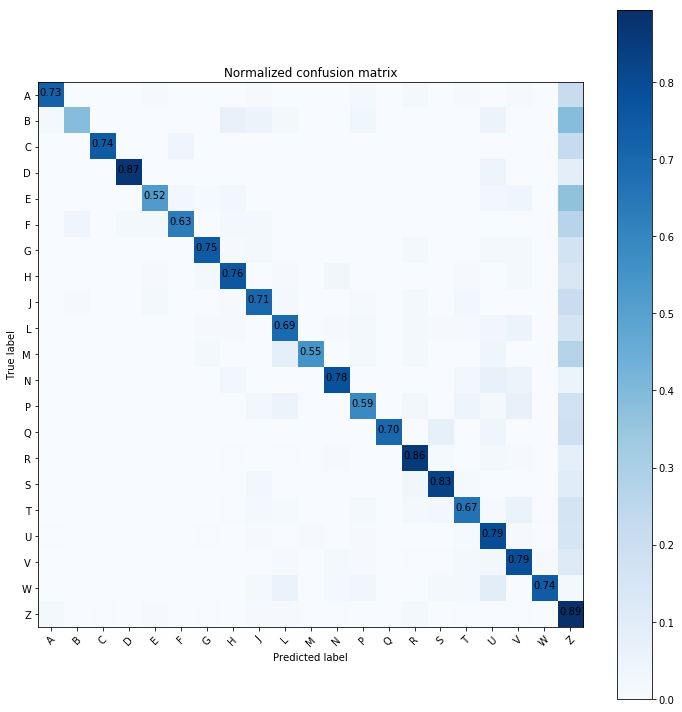

In [61]:
import itertools 
import matplotlib.pyplot as plt 

class_names = sorted(df.code.unique())

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = 0.5#cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] >  thresh :
            plt.text(j, i, "%.2f" % cm[i, j],
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, pred)
#np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')

plt.show()

Une fois que l'on est satisfait de notre classifieur, on peut prédire les codes pour les offres du bon coin. Ici on n'a évidemment pas de moyens autres que manuels de savoir si on a une bonne performance puisque ces offres n'ont pas été codées, toutefois on a testé une codification parallèle par Sicore, donc a minima on peut comparer les 2 dans les cas où Sicore a réussi à coder.

In [62]:
pred_lbc = clf.predict(X_full)
sicore_fap = lbc.fap2009_agreg

score = metrics.accuracy_score(sicore_fap, pred_lbc)
print("accuracy:   %0.3f" % score)
f1 = metrics.f1_score(sicore_fap, pred_lbc,average='macro') # unweighted mean
print("f1:   %0.3f" % f1)
precision = metrics.precision_score(sicore_fap, pred_lbc,average='macro')
print("precision:   %0.3f" % precision)
recall = metrics.recall_score(sicore_fap, pred_lbc,average='macro')
print("recall:   %0.3f" % recall)
print("classification report:")
print(metrics.classification_report(sicore_fap, pred_lbc))

accuracy:   0.453
f1:   0.361
precision:   0.529
recall:   0.338
classification report:
             precision    recall  f1-score   support

          A       0.89      0.72      0.80       479
          B       0.42      0.06      0.10      2866
          C       0.64      0.07      0.12       240
          D       0.24      0.03      0.05      1046
          E       0.11      0.01      0.02      1077
          F       0.03      0.02      0.02       167
          G       0.72      0.22      0.33      2821
          H       0.30      0.74      0.42        97
          J       0.96      0.43      0.59      3886
          K       0.00      0.00      0.00        61
          L       0.70      0.21      0.32       976
          M       0.76      0.12      0.21       231
          N       0.04      0.07      0.05        15
          P       0.04      0.17      0.07        48
          Q       0.78      0.05      0.09       141
          R       0.95      0.77      0.85      5082
          